In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [2]:
import tensorflow as tf

from tensorflow.keras import layers, regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
# from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile
import os
import pathlib

In [4]:
logdir = os.path.join(tempfile.mkdtemp(),'tensorboard_logs')
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [6]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type='GZIP')

In [7]:
def pack_row(*row):
    label = row[0]
    features =tf.stack(row[1:],1)
    return features, label

In [8]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


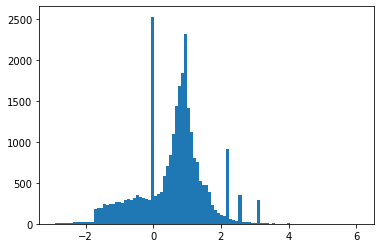

In [9]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [12]:
n_val = int(1e3)
n_train = int(1e4)
buffer_size = int(1e4)
batch_size = 500
steps_per_epoch = n_train//batch_size

In [13]:
val_ds = packed_ds.take(n_val).cache()
train_ds = packed_ds.skip(n_val).take(n_train).cache()

In [14]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [15]:
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.shuffle(buffer_size).repeat().batch(batch_size)


In [16]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = steps_per_epoch*1000,
    decay_rate=1,
    staircase = False
)
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

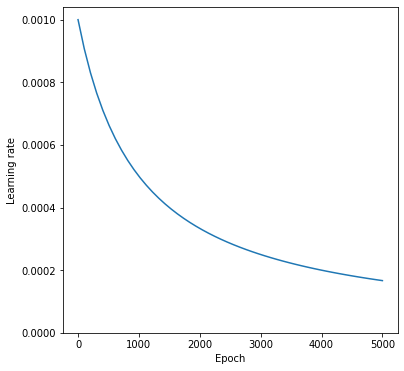

In [21]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(6,6))
plt.plot(step/steps_per_epoch, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()

In [33]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir+'/'+name),
    ]

In [30]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                  metrics=[tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                      'accuracy'])
    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch = steps_per_epoch,
        epochs = max_epochs,
        validation_data = val_ds,
        callbacks = get_callbacks(name),
        verbose = 0
    )
    return history

## Tiny model

In [31]:
tiny_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1)
])

In [34]:
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                464       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4839,  binary_crossentropy:0.8666,  loss:0.8666,  val_accuracy:0.4790,  val_binary_crossentropy:0.7593,  val_loss:0.7593,  
....................................................................................................
Epoch: 100, accuracy:0.5948,  binary_crossentropy:0.6293,  loss:0.6293,  val_accuracy:0.5600,  val_binary_crossentropy:0.6355,  val_loss:0.6355,  
..........................................................

(0.5, 0.7)

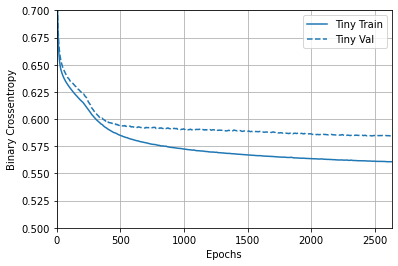

In [35]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])